# Sepsis Analysis and Prediction

This notebook contains:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Supervised Learning (Random Forest & XGBoost)
4. Unsupervised Learning (KMeans)
5. Model Evaluation and Saving

In [1]:
%pip install --upgrade scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\bhave\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.cluster import KMeans
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import pickle

## 1. Data Loading and EDA

In [3]:
# Load the training and testing datasets
train_data = pd.read_csv('../data/Patients_Files_Train.csv')
test_data = pd.read_csv('../data/Patients_Files_Test.csv')

# Display basic information about the datasets
print("Training Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   

##  Univariate  Analysis

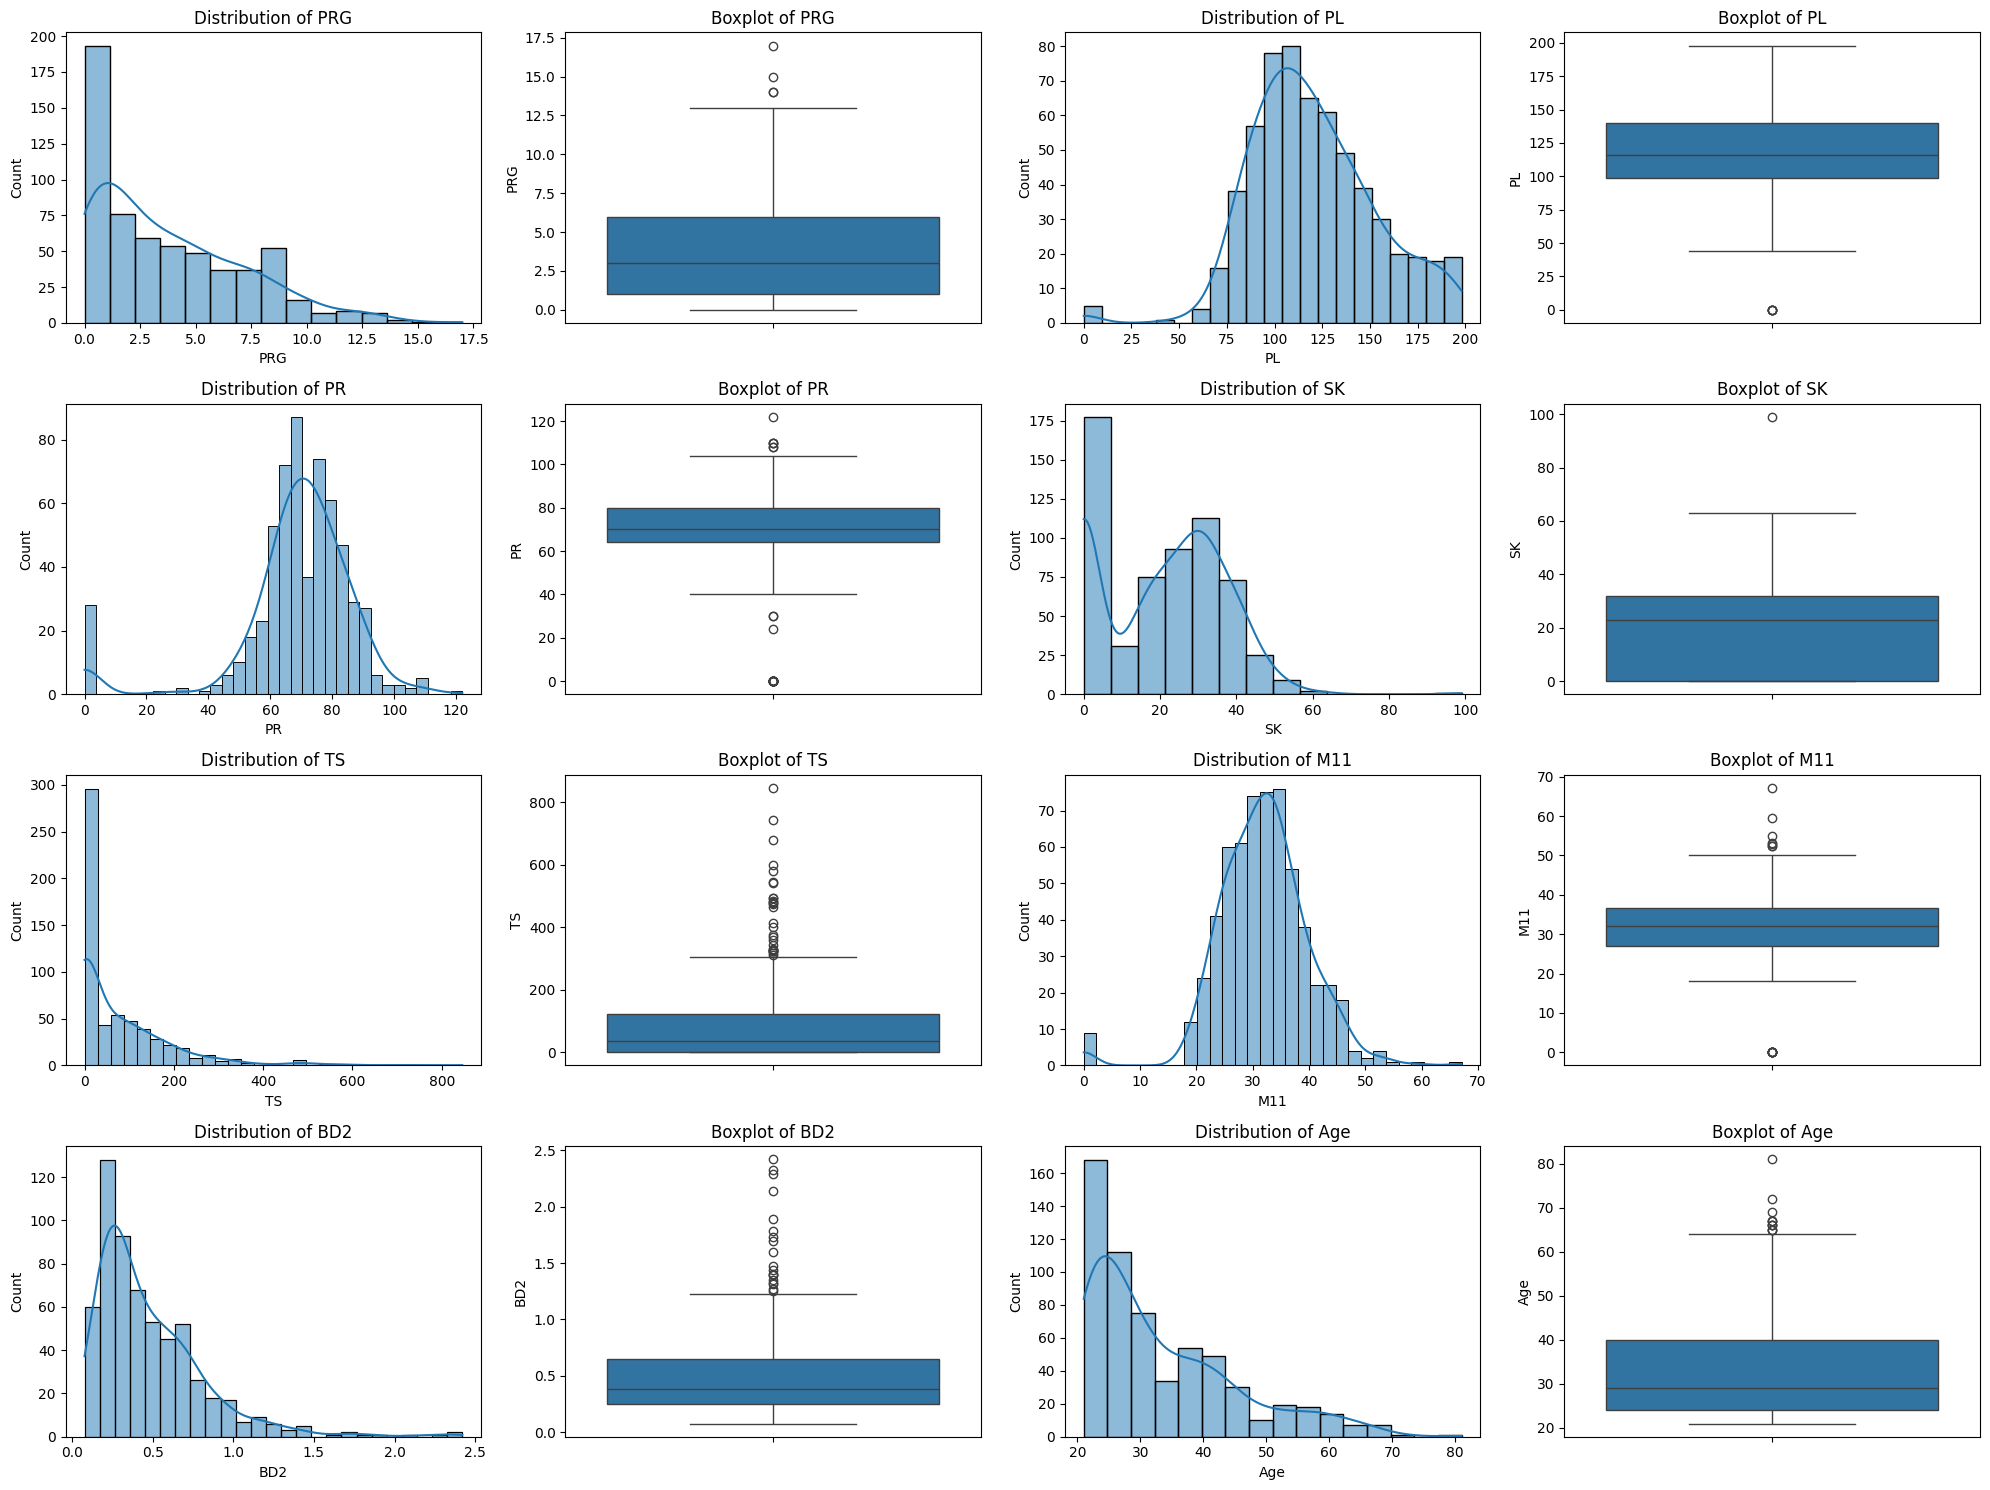

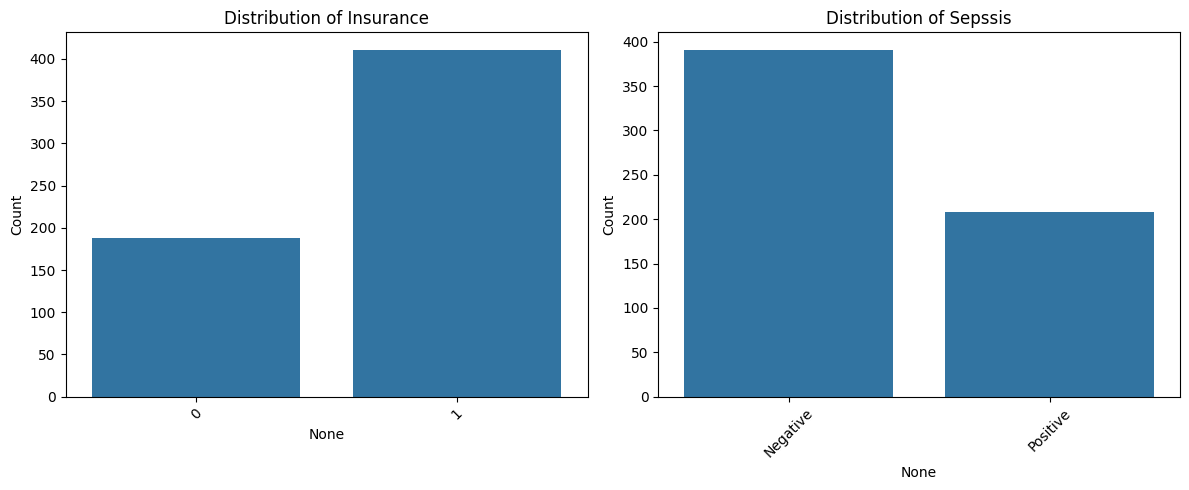


Numerical Features Summary Statistics:
              PRG          PL          PR          SK          TS         M11  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     3.824708  120.153589   68.732888   20.562604   79.460768   31.920033   
std      3.362839   32.682364   19.335675   16.017622  116.576176    8.008227   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   64.000000    0.000000    0.000000   27.100000   
50%      3.000000  116.000000   70.000000   23.000000   36.000000   32.000000   
75%      6.000000  140.000000   80.000000   32.000000  123.500000   36.550000   
max     17.000000  198.000000  122.000000   99.000000  846.000000   67.100000   

              BD2         Age  
count  599.000000  599.000000  
mean     0.481187   33.290484  
std      0.337552   11.828446  
min      0.078000   21.000000  
25%      0.248000   24.000000  
50%      0.383000   29.000000  
75%   

In [4]:
# Numerical Features
numerical_features = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

# Create subplots for numerical features
plt.figure(figsize=(20, 15))
for idx, feature in enumerate(numerical_features, 1):
    # Create subplot
    plt.subplot(4, 4, idx*2-1)
    # Histogram
    sns.histplot(data=train_data, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    
    # Boxplot
    plt.subplot(4, 4, idx*2)
    sns.boxplot(data=train_data, y=feature)
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

# Categorical Features
categorical_features = ['Insurance', 'Sepssis']

# Create subplots for categorical features
plt.figure(figsize=(12, 5))
for idx, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, idx)
    value_counts = train_data[feature].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribution of {feature}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nNumerical Features Summary Statistics:")
print(train_data[numerical_features].describe())

print("\nCategorical Features Value Counts:")
for feature in categorical_features:
    print(f"\n{feature} Distribution:")
    print(train_data[feature].value_counts(normalize=True).round(3) * 100, "%")

In [5]:
# Check for duplicates and remove them
print("Duplicates in training data:", train_data.duplicated().sum())
print("Duplicates in test data:", test_data.duplicated().sum())

# Remove duplicates
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

Duplicates in training data: 0
Duplicates in test data: 0


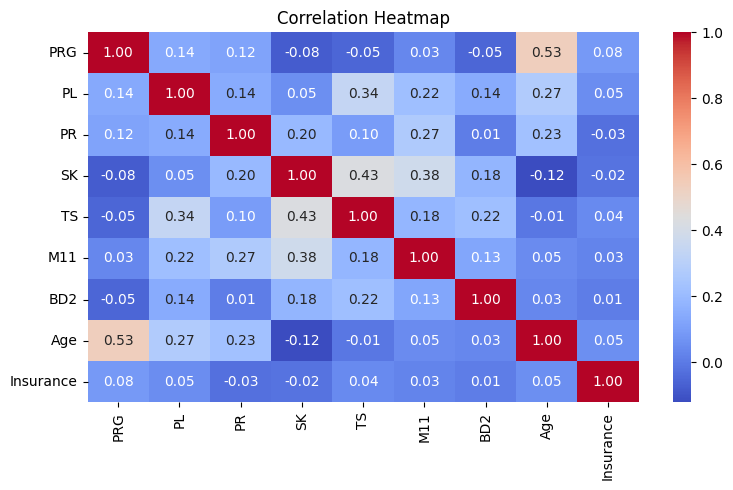

In [6]:
# EDA Visualizations
plt.figure(figsize=(15, 5))

# Distribution of target variable (if present in training data)
if 'Sepsis' in train_data.columns:
    plt.subplot(1, 2, 1)
    sns.countplot(data=train_data, x='Sepsis')
    plt.title('Distribution of Sepsis Cases')

# Correlation heatmap
plt.subplot(1, 2, 2)
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
sns.heatmap(train_data[numeric_cols].corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

##  Bivariate   Analysis

In [7]:
# Creating the Age Group Column
# Define age intervals
age_intervals = [20, 40, 60, 80, 90]
age_labels = ['20-39', '40-59', '60-79', '80-90']

# Create labels for age intervals
train_data['Age Group'] = pd.cut(train_data['Age'], bins=age_intervals, labels=age_labels)
test_data['Age Group'] = pd.cut(test_data['Age'], bins=age_intervals, labels=age_labels)

# Add a new column 'Age Group' based on age intervals
train_data['Age Group'] = pd.cut(train_data['Age'], bins=age_intervals, labels=age_labels)
train_data.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,Age Group
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive,40-59
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative,20-39
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive,20-39
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative,20-39
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive,20-39


## i. Bivariate Analysis between Age and Number of Pregnancies (PRG)

- Analyzing the relationship between age and the number of pregnancies in the context of sepsis is crucial for understanding potential health implications, especially for women. The number of pregnancies (parity) can significantly impact a woman's health and may influence her susceptibility to various medical conditions, including sepsis.


- Investigating how the number of pregnancies relates to age is essential to determine whether women with higher parity become more susceptible to sepsis as they age. This analysis can shed light on whether specific age groups of women might require more attention and care in terms of sepsis risk assessment and prevention.


- Sepsis is a medical emergency that can affect individuals of all ages, making it important to explore how age might influence its occurrence. By examining age-specific trends in the number of pregnancies, we can identify potential age groups that may be at higher risk of sepsis due to their reproductive history.

In [8]:
# Calculate the average number of pregnancies ('PRG') per age group and round to the nearest whole number
average_pregnancies_by_age = train_data.groupby('Age Group')['PRG'].mean().round().reset_index()

# Rename the columns for clarity
average_pregnancies_by_age.columns = ['Age Group', 'Average Pregnancies']

# Display the DataFrame
average_pregnancies_by_age

,Age Group,Average Pregnancies
0,20-39,3.0
1,40-59,7.0
2,60-79,4.0
3,80-90,9.0


C:\Users\bhave\AppData\Local\Temp\ipykernel_16104\1868776744.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=train_data, x='Age Group', y='PRG', palette='viridis', ci=None)
C:\Users\bhave\AppData\Local\Temp\ipykernel_16104\1868776744.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_data, x='Age Group', y='PRG', palette='viridis', ci=None)


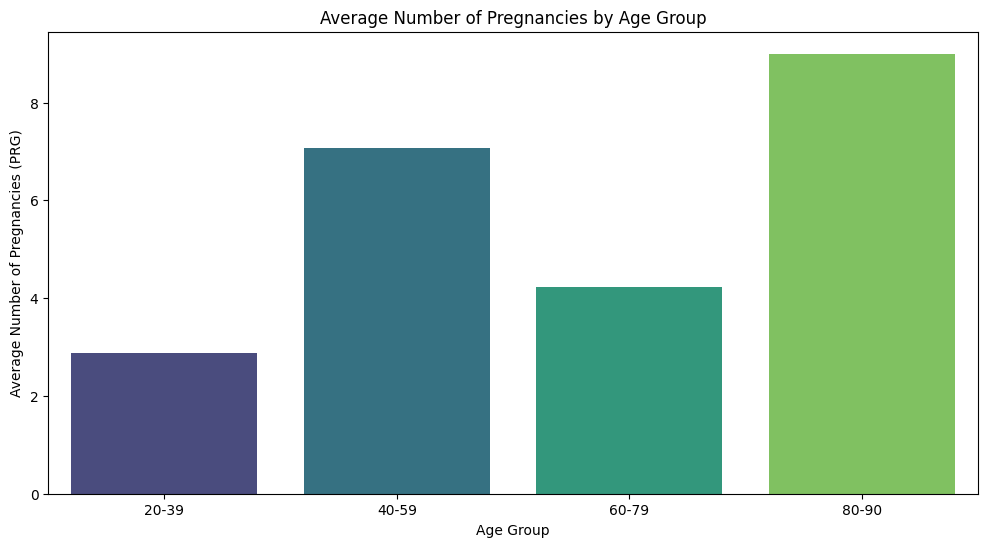

In [9]:
# Create a bar plot to visualize the average number of pregnancies ('PRG') by age group
plt.figure(figsize=(12, 6))
sns.barplot(data=train_data, x='Age Group', y='PRG', palette='viridis', ci=None)
plt.title('Average Number of Pregnancies by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Number of Pregnancies (PRG)')
plt.xticks(rotation=0)
plt.show()

## ii. Bivariate Analysis between 'Age' and 'PL' (Age vs. Plasma Glucose Concentration)

Plasma Glucose Concentration (PL) and age are critical factors in the context of sepsis. Elevated PL levels, often due to diabetes or stress-induced hyperglycemia, can weaken the immune system, increasing sepsis risk. Sepsis can affect all age groups, but its presentation varies with age. Understanding these factors is crucial for sepsis detection and management.

In [10]:
# Calculate the mean 'PL' for each age group
age_vs_pl_mean = train_data.groupby('Age Group')['PL'].mean().reset_index()

# Rename the columns for clarity
age_vs_pl_mean.columns = ['Age Group', 'Mean PL']

# Display the DataFrame
age_vs_pl_mean

,Age Group,Mean PL
0,20-39,116.669623
1,40-59,129.563492
2,60-79,137.857143
3,80-90,134.000000


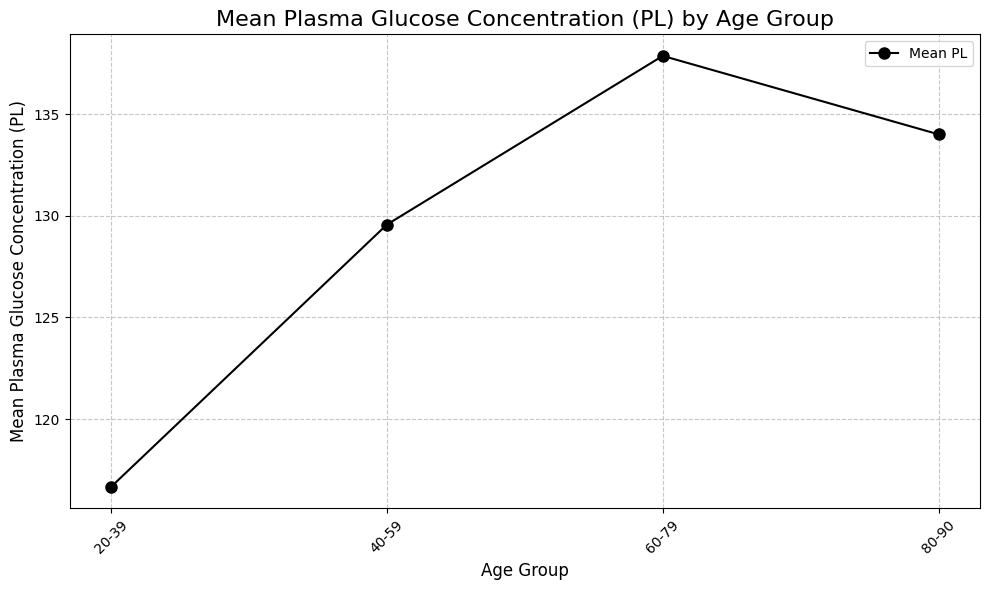

In [11]:
# Calculate the mean 'PL' for each age group
age_vs_pl_mean = train_data.groupby('Age Group')['PL'].mean().reset_index()
age_vs_pl_mean.columns = ['Age Group', 'Mean PL']

# Create a Matplotlib figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the line plot
plt.plot(age_vs_pl_mean['Age Group'], age_vs_pl_mean['Mean PL'], marker='o', markersize=8, color='black', label='Mean PL', linestyle='-')

# Customize plot aesthetics
plt.title('Mean Plasma Glucose Concentration (PL) by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Mean Plasma Glucose Concentration (PL)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

- In the age group of 20-40, the mean plasma glucose concentration is approximately 116.67. This group represents younger individuals, and their mean PL falls within the expected range for their age.


- As individuals age into the 40-60 group, the mean PL increases to approximately 129.56. This uptrend suggests that plasma glucose concentration tends to rise with age within this age bracket.


- Moving into the 60-80 age group, the mean PL further increases to about 137.86. This observation signifies a notable elevation in plasma glucose concentration among individuals in this age range, which may be associated with age-related factors or underlying health conditions.


- Lastly, in the 80-90 age group, the mean PL remains relatively stable at 134. This age group, representing the elderly, maintains a moderately high plasma glucose concentration.


- These insights highlight the relationship between age and plasma glucose concentration, indicating a progressive increase in plasma glucose concentration ('PL') with advancing age, particularly from middle age to old age.

Older age groups may be at higher risk of sepsis due to elevated PL levels, emphasizing the importance of monitoring and managing blood glucose in sepsis prevention.

## iii. Bivariate Analysis between 'Age' and 'PR' (Age vs. Diastolic Blood Pressure)

The relationship between 'Age' and 'PR' (Diastolic Blood Pressure) is essential to understand their potential impact on sepsis. Diastolic blood pressure ('PR') is a crucial cardiovascular parameter that varies with age and can be indicative of overall cardiovascular health. Age, on the other hand, is a significant factor in sepsis risk, as sepsis can affect individuals across different age groups, but its presentation and severity may vary.

To visualize this relationship more clearly, we'll group patients into age intervals and examine the mean diastolic blood pressure within each group.

In [12]:
# Calculate the mean 'PR' for each age group
age_vs_pr_mean = train_data.groupby('Age Group')['PR'].mean().reset_index()

# Rename the columns for clarity
age_vs_pr_mean.columns = ['Age Group', 'Mean PR']

# Display the DataFrame
age_vs_pr_mean

,Age Group,Mean PR
0,20-39,66.567627
1,40-59,75.690476
2,60-79,73.238095
3,80-90,74.000000


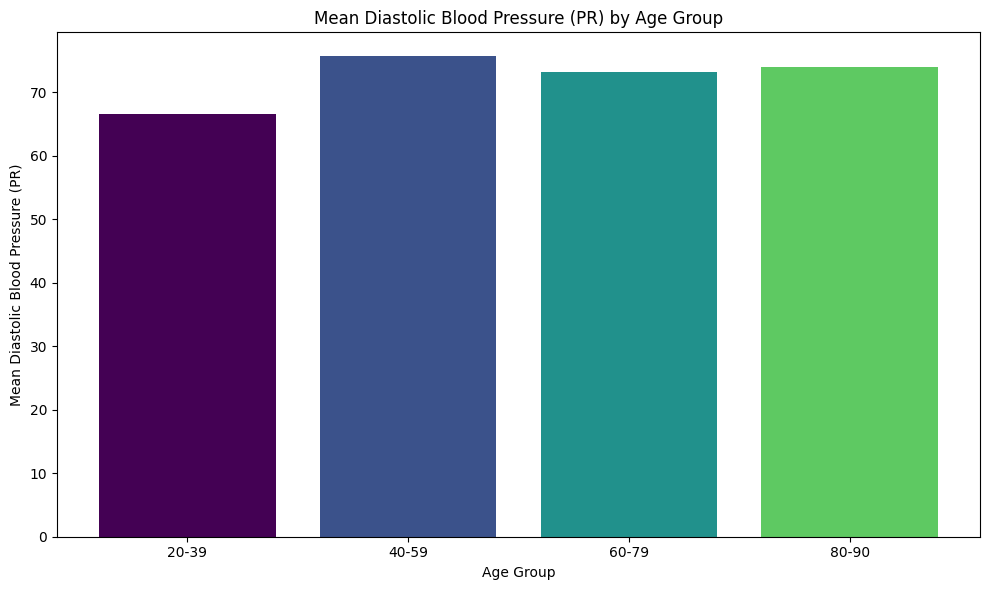

In [13]:
# Calculate the mean 'PR' for each age group
age_vs_pr_mean = train_data.groupby('Age Group')['PR'].mean().reset_index()
age_vs_pr_mean.columns = ['Age Group', 'Mean PR']

# Set the Viridis color palette
viridis_colors = plt.cm.viridis(age_vs_pr_mean.index / len(age_vs_pr_mean))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(age_vs_pr_mean['Age Group'], age_vs_pr_mean['Mean PR'], color=viridis_colors)
plt.title('Mean Diastolic Blood Pressure (PR) by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mean Diastolic Blood Pressure (PR)')

# Show the plot
plt.tight_layout()
plt.show()

The analysis of the relationship between age and the Diabetes Pedigree Function (BD2) reveals relatively consistent values across different age groups. 

- The mean BD2 remains relatively stable, ranging from approximately 0.460 to 0.488, with no significant upward or downward trend observed with increasing age. 


- This suggests that age may not be a prominent factor influencing variations in BD2 among the analyzed age groups. 

While other factors may contribute to differences in BD2, such as genetic predisposition and family history of diabetes, the age factor does not appear to be a major driver of these variations within the given dataset.

## vi. Bivariate Analysis between 'Age' and 'Sepssis' (Age vs. Sepsiss)

In [14]:
# Separate positive and negative cases into two DataFrames
positive_df = train_data[train_data['Sepssis'] == 'Positive']
negative_df = train_data[train_data['Sepssis'] == 'Negative']

# Create DataFrames showing the counts for each age group
sepsis_positive_counts = positive_df['Age Group'].value_counts().reset_index()
sepsis_positive_counts.columns = ['Age Group', 'Count']
sepsis_negative_counts = negative_df['Age Group'].value_counts().reset_index()
sepsis_negative_counts.columns = ['Age Group', 'Count']

# Display the DataFrames
print("Sepsis Positive Counts:")
sepsis_positive_counts

Sepsis Positive Counts:


,Age Group,Count
0,20-39,132
1,40-59,71
2,60-79,5
3,80-90,0


In [15]:
print("\nSepsis Negative Counts:")
sepsis_negative_counts


Sepsis Negative Counts:


,Age Group,Count
0,20-39,319
1,40-59,55
2,60-79,16
3,80-90,1


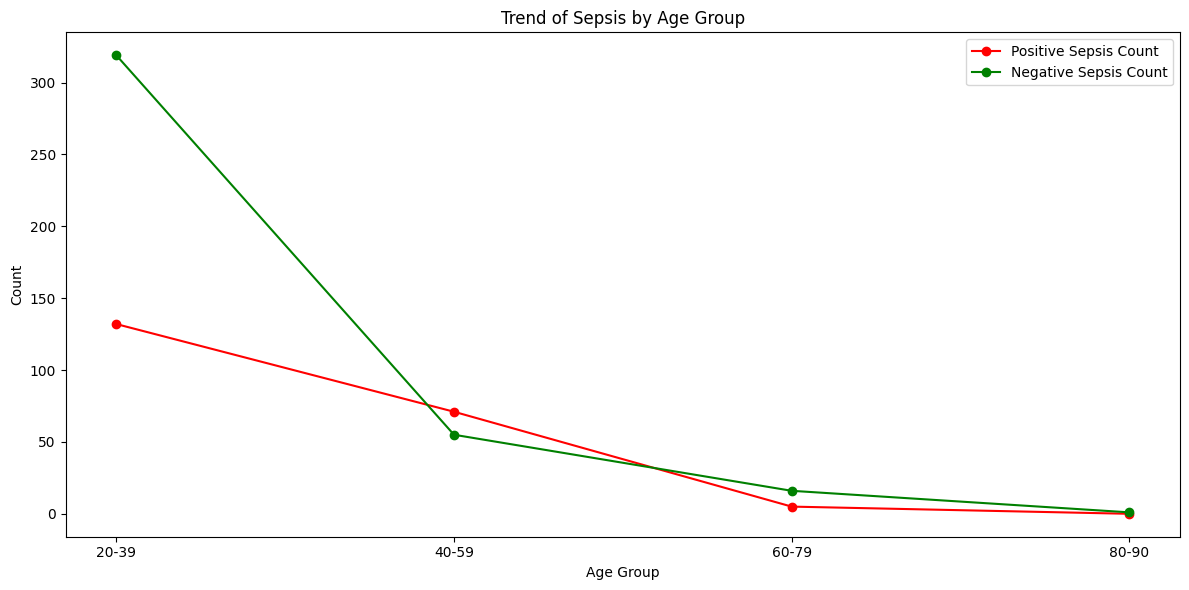

In [16]:
# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(sepsis_positive_counts['Age Group'], sepsis_positive_counts['Count'], marker='o', color='red', label='Positive Sepsis Count')
plt.plot(sepsis_negative_counts['Age Group'], sepsis_negative_counts['Count'], marker='o', color='green', label='Negative Sepsis Count')
plt.title('Trend of Sepsis by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Group the data by 'Age Group' and count the number of participants in each group
age_group_counts = train_data['Age Group'].value_counts().reset_index()
age_group_counts.columns = ['Age Group', 'Participant Count']

# Sort the DataFrame by 'Age Group'
age_group_counts = age_group_counts.sort_values(by='Age Group')

# Display the DataFrame.
age_group_counts

,Age Group,Participant Count
0,20-39,451
1,40-59,126
2,60-79,21
3,80-90,1


i. 20-39 Age Group (Highest Participant Count):

- The '20-39' age group has the highest number of participants, with 451 individuals.
- Given its larger sample size, this age group provides a more extensive pool of individuals for sepsis cases to be identified. - Consequently, it's more likely to observe a higher number of both positive and negative sepsis cases in this age group.


ii. 40-59 Age Group:

- The '40-59' age group, while having a substantial number of participants (126 individuals), is smaller in comparison to the '20-39' age group.
- This age group still provides a reasonable sample size for sepsis cases, resulting in a notable number of both positive and negative cases.


iii. 60-79 Age Group:

- The '60-79' age group has a significantly lower number of participants, with only 21 individuals.
- With a smaller sample size, the likelihood of identifying sepsis cases, both positive and negative, is reduced. This is evident in the much lower counts of cases in this age group.

iv. 80-90 Age Group (Lowest Participant Count):

- The '80-90' age group has the lowest number of participants, with only 1 individual.
- Due to the extremely small sample size, it becomes highly challenging to make meaningful observations about sepsis cases in this age group. With only one participant, there's very limited data available.

In summary, the variation in the number of participants across age groups directly impacts the ability to detect and analyze sepsis cases. Larger sample sizes, such as in the '20-39' and '40-59' age groups, provide more statistical power to identify and study sepsis cases, whereas smaller sample sizes, as seen in the '60-79' and '80-90' age groups, limit the ability to draw meaningful conclusions about sepsis incidence. 

# Feature Engineering

In [18]:
# Define age intervals
age_intervals = [20, 40, 60, 80, 90]
age_labels = ['20-39', '40-59', '60-79', '80-90']

# Create 'Age Group' column in both train_data and test_data based on age intervals
train_data['Age Group'] = pd.cut(train_data['Age'], bins=age_intervals, labels=age_labels)
test_data['Age Group'] = pd.cut(test_data['Age'], bins=age_intervals, labels=age_labels)

# Define columns to impute
columns_to_impute = ['PL', 'PR', 'SK', 'M11']

# Loop through each column for imputation
for column in columns_to_impute:
    # Identify rows with a value of 0 in the column for both train and test datasets
    zero_rows_train = train_data[train_data[column] == 0]
    zero_rows_test = test_data[test_data[column] == 0]
    
    # Iterate through age groups
    for age_group in age_labels:
        # Calculate the mean of the column within the specific age group for both datasets
        age_group_mean_train = train_data[train_data['Age Group'] == age_group][column].mean()
        age_group_mean_test = test_data[test_data['Age Group'] == age_group][column].mean()
        
        # Impute the mean for rows in the specific age group for both datasets
        train_data.loc[(train_data['Age Group'] == age_group) & (train_data[column] == 0), column] = age_group_mean_train
        test_data.loc[(test_data['Age Group'] == age_group) & (test_data[column] == 0), column] = age_group_mean_test

# Print some statistics to verify the imputation
print("\nVerification after imputation:")
print("\nTraining data summary:")
print(train_data[columns_to_impute].describe())
print("\nTest data summary:")
print(test_data[columns_to_impute].describe())


Verification after imputation:

Training data summary:
               PL          PR          SK         M11
count  599.000000  599.000000  599.000000  599.000000
mean   121.148985   71.901390   26.360109   32.398889
std     30.767905   11.961464   10.091526    6.969327
min     44.000000   24.000000    7.000000   18.200000
25%     99.000000   64.000000   19.000000   27.400000
50%    116.669623   70.000000   23.000000   32.000000
75%    140.000000   80.000000   32.000000   36.550000
max    198.000000  122.000000   99.000000   67.100000

Test data summary:
               PL          PR          SK         M11
count  169.000000  169.000000  169.000000  169.000000
mean   123.520710   73.274787   26.588964   32.600409
std     29.259123   12.783183    9.091937    6.562578
min     56.000000   38.000000   10.000000   19.500000
25%    102.000000   64.000000   20.000000   27.700000
50%    120.000000   74.000000   23.000000   32.400000
75%    141.000000   80.000000   32.000000   36.600000
max   

In [19]:
train_data.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,121.148985,71.901390,26.360109,79.460768,32.398889,0.481187,33.290484,0.686144
std,3.362839,30.767905,11.961464,10.091526,116.576176,6.969327,0.337552,11.828446,0.464447
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,19.000000,0.000000,27.400000,0.248000,24.000000,0.000000
50%,3.000000,116.669623,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [20]:
test_data.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.917160,123.520710,73.274787,26.588964,81.000000,32.600409,0.438876,33.065089,0.727811
std,3.402415,29.259123,12.783183,9.091937,110.720852,6.562578,0.306935,11.548110,0.446410
min,0.000000,56.000000,38.000000,10.000000,0.000000,19.500000,0.100000,21.000000,0.000000
25%,1.000000,102.000000,64.000000,20.000000,0.000000,27.700000,0.223000,24.000000,0.000000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.343000,28.000000,1.000000
75%,6.000000,141.000000,80.000000,32.000000,135.000000,36.600000,0.587000,42.000000,1.000000
max,13.000000,199.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000,1.000000


## Creating New Features For Visualization

### a. BMI Categorization

In [21]:
# BMI Categorization
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

train_data['BMICategory'] = train_data['M11'].apply(categorize_bmi)
test_data['BMICategory'] = test_data['M11'].apply(categorize_bmi)

### b. Glucose Level Categorization

In [22]:
# Glucose Level Categorization
def categorize_glucose(pl):
    if pl < 100:
        return 'Normal'
    elif 100 <= pl < 126:
        return 'Prediabetic'
    else:
        return 'Diabetic'

train_data['GlucoseCategory'] = train_data['PL'].apply(categorize_glucose)
test_data['GlucoseCategory'] = test_data['PL'].apply(categorize_glucose)

### c. Diastolic Blood Pressure Categorization

In [23]:
# Diastolic Blood Pressure Category
def categorize_pr(pr):
    if pr < 80:
        return 'Normal'
    elif 80 <= pr < 90:
        return 'Prehypertension'
    elif 90 <= pr < 100:
        return 'Stage1Hypertension'
    else:
        return 'Stage2Hypertension'

train_data['PRCategory'] = train_data['PR'].apply(categorize_pr)
test_data['PRCategory'] = test_data['PR'].apply(categorize_pr)

### d. Interaction Feature (Age x Plasma Glucose Concentration (PL))

Interaction features in feature engineering are features that are created by combining two or more existing features. They are used to capture the relationship between the original features and how they affect the target variable.

In [24]:
# Interaction Feature (Age x Plasma Glucose Concentration (PL))
train_data['Age_PL_Interact'] = train_data['Age'] * train_data['PL']
test_data['Age_PL_Interact'] = test_data['Age'] * test_data['PL']

The multiplication of Age x Plasma Glucose Concentration (PL) to come up with 'Age_PL_Interact' is a metric that captures the relationship between age and plasma glucose concentration (PL) and how they affect the target variable, which is sepsis risk. 


This metric is based on the following observations:
- As people age, their bodies become less efficient at regulating blood sugar levels. This can lead to increased plasma glucose concentrations.
- Older adults are more likely to have underlying medical conditions that can increase their risk of sepsis, such as diabetes and heart disease.

This metric is also known as the Age-Plasma Glucose (APG) product. It has been used in a number of studies to predict sepsis risk.
- A patient with a higher age and plasma glucose concentration (APG) product has a higher risk of sepsis.

In [25]:
train_data.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,Age Group,BMICategory,GlucoseCategory,PRCategory,Age_PL_Interact
0,ICU200010,6,148.0,72.0,35.000000,0,33.6,0.627,50,0,Positive,40-59,Obese,Diabetic,Normal,7400.0
1,ICU200011,1,85.0,66.0,29.000000,0,26.6,0.351,31,0,Negative,20-39,Overweight,Normal,Normal,2635.0
2,ICU200012,8,183.0,64.0,21.472284,0,23.3,0.672,32,1,Positive,20-39,Normal,Diabetic,Normal,5856.0
3,ICU200013,1,89.0,66.0,23.000000,94,28.1,0.167,21,1,Negative,20-39,Overweight,Normal,Normal,1869.0
4,ICU200014,0,137.0,40.0,35.000000,168,43.1,2.288,33,1,Positive,20-39,Obese,Diabetic,Normal,4521.0


In [26]:
test_data.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Age Group,BMICategory,GlucoseCategory,PRCategory,Age_PL_Interact
0,ICU200609,1,109.0,38.000000,18.000000,120,23.1,0.407,26,1,20-39,Normal,Prediabetic,Normal,2834.0
1,ICU200610,1,108.0,88.000000,19.000000,0,27.1,0.400,24,1,20-39,Overweight,Prediabetic,Prehypertension,2592.0
2,ICU200611,6,96.0,67.081301,21.382114,0,23.7,0.190,28,1,20-39,Normal,Normal,Normal,2688.0
3,ICU200612,1,124.0,74.000000,36.000000,0,27.8,0.100,30,1,20-39,Overweight,Prediabetic,Normal,3720.0
4,ICU200613,7,150.0,78.000000,29.000000,126,35.2,0.692,54,0,40-59,Obese,Diabetic,Normal,8100.0


### e. Saving The Datasets For PowerBI Visualization

In [27]:
# Save the updated datasets
train_data.to_csv("../data/Visualization_Data_Train.csv", index=False)
test_data.to_csv("../data/Visualization_Data_Test.csv", index=False)

### f. Dropping The New Features Created For Visualization and Other Unneccessary Columns

In [28]:
# Drop unnecessary columns
train_data.drop(['ID', 'Age Group', 'Insurance', 'BMICategory', 'GlucoseCategory', 'PRCategory', 'Age_PL_Interact' ], axis=1, inplace=True)
test_data.drop(['ID', 'Age Group', 'Insurance', 'BMICategory', 'GlucoseCategory', 'PRCategory', 'Age_PL_Interact' ], axis=1, inplace=True)

In [29]:
train_data.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148.0,72.0,35.000000,0,33.6,0.627,50,Positive
1,1,85.0,66.0,29.000000,0,26.6,0.351,31,Negative
2,8,183.0,64.0,21.472284,0,23.3,0.672,32,Positive
3,1,89.0,66.0,23.000000,94,28.1,0.167,21,Negative
4,0,137.0,40.0,35.000000,168,43.1,2.288,33,Positive


## iii. Encoding Categorical Variables

In [30]:
# Initialize LabelEncoder for the target variable 'Sepssis'
label_encoder = LabelEncoder()

# Encode the target variable
train_data['Sepssis'] = label_encoder.fit_transform(train_data['Sepssis'])

In [31]:
# Display the updated train dataset
train_data.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148.0,72.0,35.000000,0,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,0,26.6,0.351,31,0
2,8,183.0,64.0,21.472284,0,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168,43.1,2.288,33,1


In [32]:
# Display the updated test dataset
test_data.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,1,109.0,38.000000,18.000000,120,23.1,0.407,26
1,1,108.0,88.000000,19.000000,0,27.1,0.400,24
2,6,96.0,67.081301,21.382114,0,23.7,0.190,28
3,1,124.0,74.000000,36.000000,0,27.8,0.100,30
4,7,150.0,78.000000,29.000000,126,35.2,0.692,54


# Modeling

## Dataset Splitting

In [33]:
# Define your features (X) and target variable (y)
X = train_data.drop('Sepssis', axis=1)
y = train_data['Sepssis']

# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of the Training Set (X_train, y_train):", X_train.shape, y_train.shape)
print("Shape of the Evaluation Set (X_eval, y_eval):", X_eval.shape, y_eval.shape)

Shape of the Training Set (X_train, y_train): (479, 8) (479,)
Shape of the Evaluation Set (X_eval, y_eval): (120, 8) (120,)


## Balancing the Training Set

In [34]:
# Check the class distribution in the training set
print("Class distribution before balancing:")
print(y_train.value_counts())

Class distribution before balancing:
0    313
1    166
Name: Sepssis, dtype: int64


C:\Users\bhave\AppData\Local\Temp\ipykernel_16104\3552098330.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


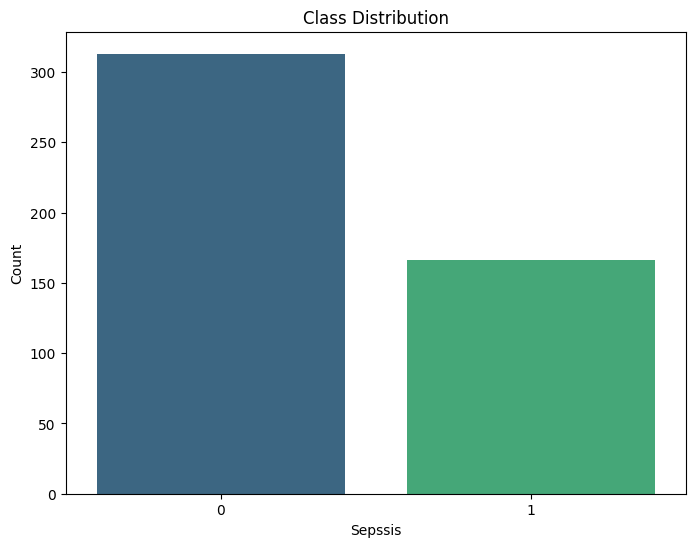

In [35]:
# Count the occurrences of each class in the dataset
class_counts = y_train.value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Sepssis')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

0 Class (No Sepsis): There are 313 instances without Sepsis in the Training Set.

1 Class (Sepsis): There are 166 instances of participants with Sepsis in the Training Set.

The class distribution shows that there is some class imbalance, with the "0" class (no sepsis) having more instances than the "1" class (sepsis). Addressing this class imbalance is important to ensure that the machine learning model can make accurate predictions for both classes and is not biased towards the majority class.

In [36]:
# Balance the training set using Random Oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after balancing
balanced_class_counts = y_train_balanced.value_counts()
print("\nClass distribution in the balanced training set:")
print(balanced_class_counts)


Class distribution in the balanced training set:
0    313
1    313
Name: Sepssis, dtype: int64


C:\Users\bhave\AppData\Local\Temp\ipykernel_16104\3821933149.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


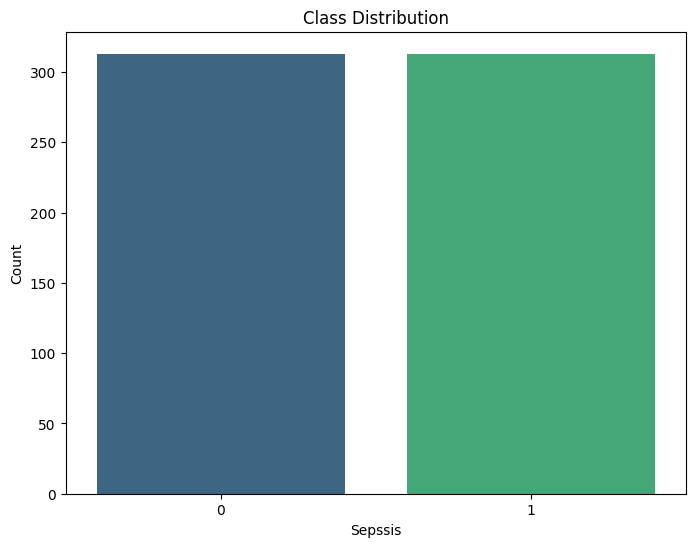

In [37]:
# Count the occurrences of each class in the balanced dataset
class_counts = y_train_balanced.value_counts()

# Create a bar plot with the 'viridis' color palette
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Sepssis')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

The train set is now balanced.

## Scaling The Training and Evaluation Sets

In [38]:
# Scale the training and evaluation sets
scaler = MinMaxScaler()

# Keep track of feature names
feature_columns = X_train_balanced.columns

# Scale the training data and preserve column names
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_balanced),
    columns=feature_columns
)

# Scale the evaluation data using the same scaler
X_eval_scaled = scaler.transform(X_eval)

In [39]:
# Convert scaled NumPy arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_eval_scaled_df = pd.DataFrame(X_eval_scaled, columns=X.columns)

# Now, X_train_scaled_df and X_eval_scaled_df are DataFrames containing the scaled features.

# Additionally, convert the balanced target variable back to a DataFrame as well
y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=['Sepssis'])

# Now, y_train_balanced_df is a DataFrame containing the balanced target variable.

# Confirm the shapes of the DataFrames
print("Shape of X_train_scaled_df:", X_train_scaled_df.shape)
print("Shape of X_eval_scaled_df:", X_eval_scaled_df.shape)
print("Shape of y_train_balanced_df:", y_train_balanced_df.shape)
print("Shape of y_eval:", y_eval.shape)

Shape of X_train_scaled_df: (626, 8)
Shape of X_eval_scaled_df: (120, 8)
Shape of y_train_balanced_df: (626, 1)
Shape of y_eval: (120,)


In [40]:
# View the first few rows of the scaled X_train
X_train_scaled_df.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,0.411765,0.319149,0.478261,0.358696,0.141129,0.461165,0.051370,0.400000
1,0.411765,0.879433,0.586957,0.152174,0.258065,0.429612,0.214897,0.500000
2,0.117647,0.170213,0.456522,0.086957,0.102151,0.288835,0.198202,0.066667
3,0.176471,0.872340,0.369565,0.195652,0.094086,0.383495,0.080051,0.083333
4,0.000000,0.191489,0.369565,0.163043,0.088710,0.427184,0.197346,0.000000


In [41]:
# View the first few rows of the scaled X_eval
X_eval_scaled_df.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,0.176471,0.219858,0.304348,0.043478,0.072581,0.160194,0.078339,0.016667
1,0.529412,0.702128,0.608696,0.228261,0.208333,0.390777,0.473031,0.350000
2,0.000000,0.312057,0.347826,0.157307,0.000000,0.089806,0.107877,0.066667
3,0.117647,0.631206,0.500000,0.304348,0.260753,0.485437,0.104880,0.133333
4,0.000000,0.404255,0.543478,0.293478,0.383065,0.631068,0.035531,0.100000


## Model Training and Evaluation

### Model Training

In [42]:
# Initialize an empty dictionary named 'Results' to store the evaluation results for different models.
Results = {'Model':[], 'Acurracy':[], 'Precision':[], 'Recall':[], 'F1':[]}

In [43]:
# Converting the dictionary Results into a pandas DataFrame.
Results = pd.DataFrame(Results)
Results.head()

,Model,Acurracy,Precision,Recall,F1


In [44]:
# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=None,         # Let trees expand until all leaves are pure
    random_state=42,        # For reproducibility
    n_jobs=-1               # Use all CPU cores
)

# XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=100,       # Number of boosting rounds
    learning_rate=0.1,      # Step size shrinkage
    max_depth=6,            # Maximum tree depth
    subsample=0.8,          # Subsample ratio of training instances
    colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
    use_label_encoder=False,
    eval_metric='logloss',  # Avoid warning for default metric
    random_state=42
)

# Import additional classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize all classifiers
svm = SVC(kernel='rbf', random_state=42)
lr = LogisticRegression(random_state=42, max_iter=1000)
dt = DecisionTreeClassifier(random_state=42)

C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model: Random Forest
Confusion Matrix:
[[59 19]
 [14 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78        78
           1       0.60      0.67      0.63        42

    accuracy                           0.72       120
   macro avg       0.70      0.71      0.71       120
weighted avg       0.73      0.72      0.73       120

Accuracy: 0.72
Precision: 0.6
Recall: 0.67
F1: 0.63


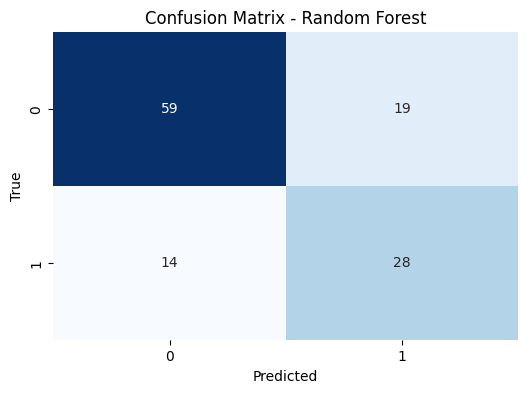

C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [15:57:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
Confusion Matrix:
[[60 18]
 [15 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78        78
           1       0.60      0.64      0.62        42

    accuracy                           0.72       120
   macro avg       0.70      0.71      0.70       120
weighted avg       0.73      0.72      0.73       120

Accuracy: 0.72
Precision: 0.6
Recall: 0.64
F1: 0.62


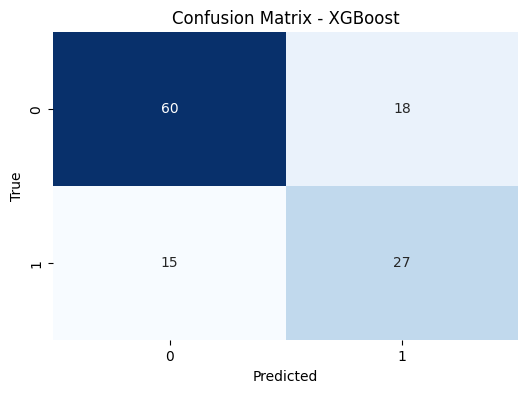

Model: SVM
Confusion Matrix:
[[58 20]
 [15 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        78
           1       0.57      0.64      0.61        42

    accuracy                           0.71       120
   macro avg       0.68      0.69      0.69       120
weighted avg       0.72      0.71      0.71       120

Accuracy: 0.71
Precision: 0.57
Recall: 0.64
F1: 0.61


C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


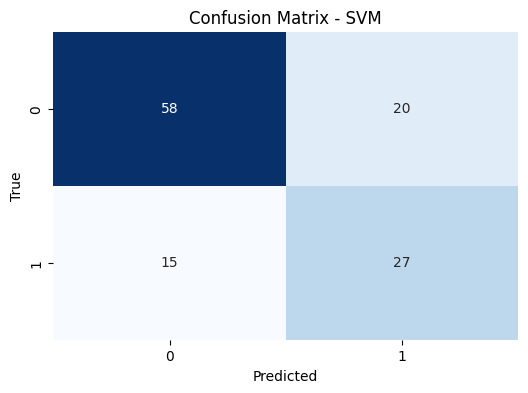

C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: Logistic Regression
Confusion Matrix:
[[55 23]
 [12 30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        78
           1       0.57      0.71      0.63        42

    accuracy                           0.71       120
   macro avg       0.69      0.71      0.70       120
weighted avg       0.73      0.71      0.71       120

Accuracy: 0.71
Precision: 0.57
Recall: 0.71
F1: 0.63


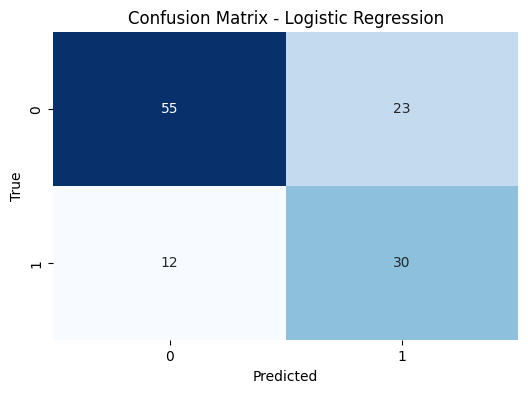

Model: Decision Tree
Confusion Matrix:
[[60 18]
 [18 24]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        78
           1       0.57      0.57      0.57        42

    accuracy                           0.70       120
   macro avg       0.67      0.67      0.67       120
weighted avg       0.70      0.70      0.70       120

Accuracy: 0.7
Precision: 0.57
Recall: 0.57
F1: 0.57


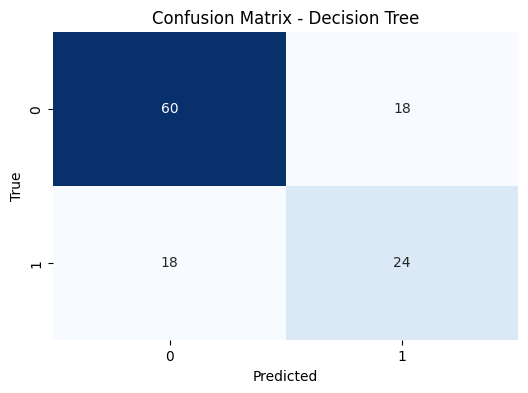


Leaderboard (Ranked by F1 Score)


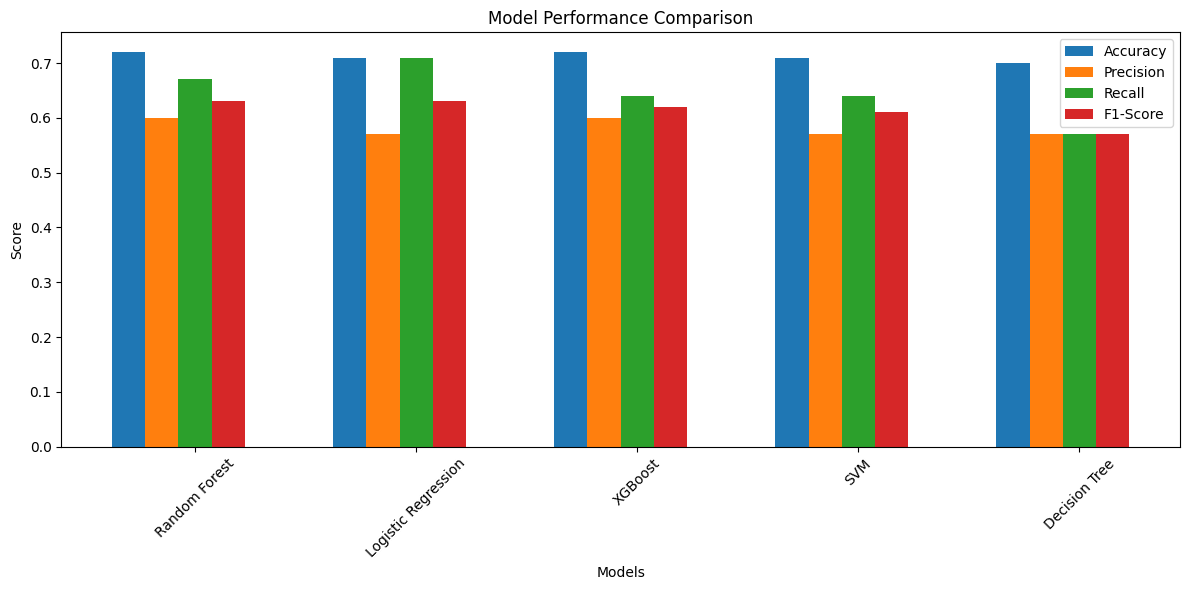

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.72,0.60,0.67,0.63
1,Logistic Regression,0.71,0.57,0.71,0.63
2,XGBoost,0.72,0.60,0.64,0.62
3,SVM,0.71,0.57,0.64,0.61
4,Decision Tree,0.70,0.57,0.57,0.57


In [45]:
# List of model names and model objects
models = ['Random Forest', 'XGBoost', 'SVM', 'Logistic Regression', 'Decision Tree']
model_objects = [rf, xgb, svm, lr, dt]

# Initialize the Results DataFrame
Results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Fit the models and evaluate the performance
for model_name, model in zip(models, model_objects):
    model.fit(X_train_scaled_df, y_train_balanced_df)
    y_pred = model.predict(X_eval_scaled_df)
    
    print('Model:', model_name)
    print('=' * 50)
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_eval, y_pred))
    
    print('Classification Report:')
    print(classification_report(y_eval, y_pred))

    accuracy = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred)

    print('Accuracy:', round(accuracy, 2))
    print('Precision:', round(precision, 2))
    print('Recall:', round(recall, 2))
    print('F1:', round(f1, 2))

    # Generate the confusion matrix
    cm = confusion_matrix(y_eval, y_pred)

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Append the results to the DataFrame with rounding to 2 decimal places
    new_row = {
        'Model': model_name,
        'Accuracy': round(accuracy, 2),
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1': round(f1, 2)
    }

    Results = pd.concat([Results, pd.DataFrame([new_row])], ignore_index=True)

# Print the leaderboard based on F1 score
print("\nLeaderboard (Ranked by F1 Score)")
Results_sorted = Results.sort_values(by='F1', ascending=False).reset_index(drop=True)
Results_sorted.rename(columns={'F1': 'F1-Score'}, inplace=True)

# Create a bar plot comparing model performances
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
bar_width = 0.15
r = np.arange(len(models))

for i, metric in enumerate(metrics):
    plt.bar(r + i * bar_width, Results_sorted[metric], bar_width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(r + bar_width * 2, Results_sorted['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Display the results
Results_sorted

### Model Evaluation

C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\bhave\AppData\Local\Temp\ipykernel_16104\2630560240.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Feature', data=rf_feature_df, palette="viridis")


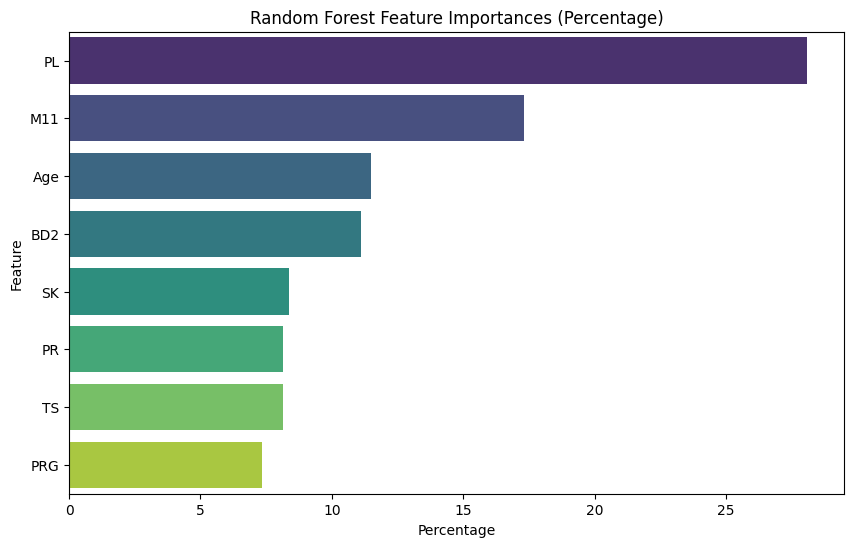

Random Forest - Exact Percentage Feature Importances:


,Feature,Importance,Percentage
1,PL,0.280851,28.09
5,M11,0.173310,17.33
7,Age,0.114756,11.48
6,BD2,0.111346,11.13
3,SK,0.083697,8.37
2,PR,0.081428,8.14
4,TS,0.081315,8.13
0,PRG,0.073298,7.33


In [46]:
# Fit the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled_df, y_train_balanced_df)

# Get feature importances
rf_importances = rf.feature_importances_

# Calculate the sum of importances for percentage calculation
rf_total_importance = rf_importances.sum()

# Create DataFrame
rf_feature_df = pd.DataFrame({'Feature': X_train_scaled_df.columns, 'Importance': rf_importances})
rf_feature_df['Percentage'] = ((rf_feature_df['Importance'] / rf_total_importance) * 100).round(2)
rf_feature_df = rf_feature_df.sort_values(by='Importance', ascending=False)

# Plot
sns.set_palette("viridis")
plt.figure(figsize=(10, 6))
sns.barplot(x='Percentage', y='Feature', data=rf_feature_df, palette="viridis")
plt.title('Random Forest Feature Importances (Percentage)')
plt.xlabel('Percentage')
plt.ylabel('Feature')
plt.show()

# Print the exact values
print("Random Forest - Exact Percentage Feature Importances:")
rf_feature_df

#### Hyperparameter Tuning

In [47]:
# Define hyperparameters for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit the grid search
rf_grid_search.fit(X_train_scaled_df, y_train_balanced_df)

# Best parameters for Random Forest
rf_best_params = rf_grid_search.best_params_
print("Random Forest - Best Hyperparameters:", rf_best_params)

Random Forest - Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### Perfomance after Hyperparameter Tuning

Random Forest - Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        78
           1       0.61      0.74      0.67        42

    accuracy                           0.74       120
   macro avg       0.72      0.74      0.73       120
weighted avg       0.76      0.74      0.75       120

Accuracy: 0.74
Precision: 0.61
Recall: 0.74
F1-score: 0.67


C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


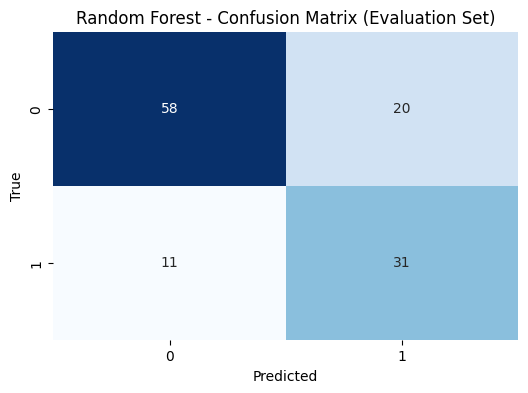

The F1-score After Random Forest Model Evaluation is: 0.67


In [48]:
# Instantiate the Random Forest Classifier with tuned hyperparameters
tuned_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42
)

# Fit the tuned model to the training data
tuned_rf.fit(X_train_scaled, y_train_balanced)

# Predict on the evaluation set
y_eval_pred_rf = tuned_rf.predict(X_eval_scaled)

# Print the classification report
print("Random Forest - Evaluation Set Classification Report:")
print(classification_report(y_eval, y_eval_pred_rf))

# Calculate and print performance metrics
accuracy_rf = accuracy_score(y_eval, y_eval_pred_rf)
precision_rf = precision_score(y_eval, y_eval_pred_rf)
recall_rf = recall_score(y_eval, y_eval_pred_rf)
f1_rf = f1_score(y_eval, y_eval_pred_rf)

print("Accuracy:", round(accuracy_rf, 2))
print("Precision:", round(precision_rf, 2))
print("Recall:", round(recall_rf, 2))
print("F1-score:", round(f1_rf, 2))

# Confusion matrix heatmap
cm_rf = confusion_matrix(y_eval, y_eval_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest - Confusion Matrix (Evaluation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("The F1-score After Random Forest Model Evaluation is:", round(f1_rf, 2))

### Save The Model and Key Components

In [49]:
# Create a dictionary to store the components
saved_components = {
    'model': tuned_rf,      
    'encoder': label_encoder, 
    'scaler': scaler   
}

# Save all components in a single pickle file
with open('../models/model_and_key_components.pkl', 'wb') as file:
    pickle.dump(saved_components, file)

#### Test Prediction

In [50]:
# View the head of the test dataset
test_data.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,1,109.0,38.000000,18.000000,120,23.1,0.407,26
1,1,108.0,88.000000,19.000000,0,27.1,0.400,24
2,6,96.0,67.081301,21.382114,0,23.7,0.190,28
3,1,124.0,74.000000,36.000000,0,27.8,0.100,30
4,7,150.0,78.000000,29.000000,126,35.2,0.692,54


In [51]:
# Create a copy of the test_df
test_pred = test_data.copy()
test_pred.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,1,109.0,38.000000,18.000000,120,23.1,0.407,26
1,1,108.0,88.000000,19.000000,0,27.1,0.400,24
2,6,96.0,67.081301,21.382114,0,23.7,0.190,28
3,1,124.0,74.000000,36.000000,0,27.8,0.100,30
4,7,150.0,78.000000,29.000000,126,35.2,0.692,54


In [52]:
# Load the model and components
with open('../models/model_and_key_components.pkl', 'rb') as file:
    loaded_components = pickle.load(file)

# Load the model, encoder and scaler
loaded_model = loaded_components['model']
loaded_encoder = loaded_components['encoder']
loaded_scaler = loaded_components['scaler']

# Encode Categorical Variables
# All Columns are numerical. No need for encoding

# Apply scaling to numerical data
numerical_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']
test_data_scaled = loaded_scaler.transform(test_pred[numerical_cols])

# Convert the scaled numerical data to a DataFrame
test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=numerical_cols)

# Perform Predictions
y_pred = loaded_model.predict(test_data_scaled_df)

# Create a new DataFrame with the 'Sepsis' predictions
test_predictions = test_pred.copy()
test_predictions['Sepsis'] = y_pred

# Define a mapping dictionary
sepsis_mapping = {0: 'Negative', 1: 'Positive'}

# Map the values in the 'Sepsis' column
test_predictions['Sepsis'] = test_predictions['Sepsis'].map(sepsis_mapping)

# Display Predictions (first few rows)
test_predictions.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
0,1,109.0,38.000000,18.000000,120,23.1,0.407,26,Negative
1,1,108.0,88.000000,19.000000,0,27.1,0.400,24,Negative
2,6,96.0,67.081301,21.382114,0,23.7,0.190,28,Negative
3,1,124.0,74.000000,36.000000,0,27.8,0.100,30,Negative
4,7,150.0,78.000000,29.000000,126,35.2,0.692,54,Positive


In [53]:
# Save the updated datasets
test_predictions.to_csv("../data/Test_Predictions.csv", index=False)

#   KMeans Clustering

###  Feature Preparation (no labels involved)

In [54]:
# Load data
df = pd.read_csv("../data/Patients_Files_Train.csv")

# Drop irrelevant columns and keep only the features needed for clustering
features_for_clustering = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']
df_clustering = df[features_for_clustering]    

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Sepsis_Cluster'] = kmeans.fit_predict(scaled_features)

# Save the KMeans model
with open('../models/kmeans_sepsis_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Save the clustered data
df.to_csv('../data/Clustered_Sepsis_Patients.csv', index=False)

print("KMeans model and clustered data saved successfully!")

KMeans model and clustered data saved successfully!


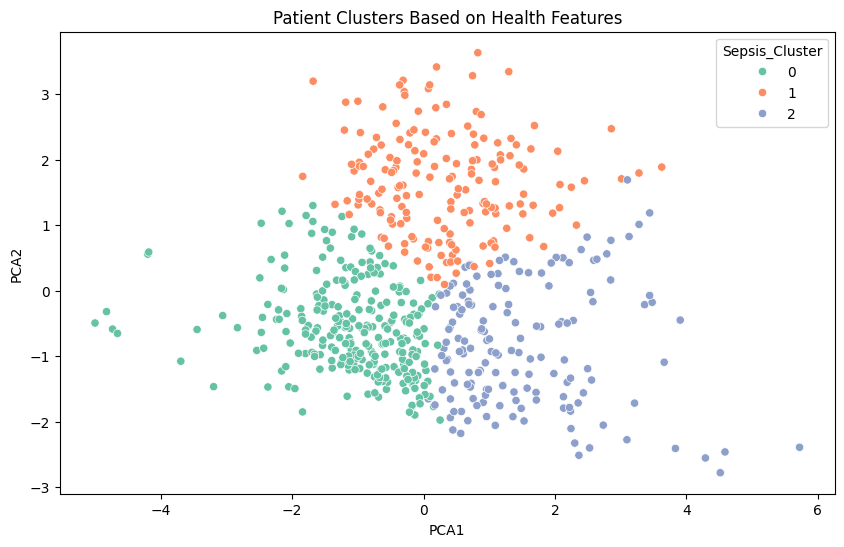

C:\Users\bhave\AppData\Local\Temp\ipykernel_16104\542953205.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = df.groupby('Sepsis_Cluster').mean()


,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,PCA1,PCA2
Sepsis_Cluster,,,,,,,,,,,
0,2.138060,101.104478,61.041045,16.694030,37.279851,28.558209,0.416694,26.287313,0.660448,-1.080254,-0.575549
1,7.325714,130.200000,76.485714,13.582857,35.920000,32.588000,0.450937,45.731429,0.714286,0.310877,1.627418
2,2.794872,141.608974,73.250000,35.038462,200.769231,36.946154,0.625917,31.365385,0.698718,1.507080,-0.836866


KMeans model and clustered data saved successfully!


In [55]:
# Choose the number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Sepsis_Cluster'] = kmeans.fit_predict(scaled_features)

# Use PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Sepsis_Cluster', palette='Set2', data=df)
plt.title('Patient Clusters Based on Health Features')
plt.show()

# View mean values of each feature by cluster
cluster_summary = df.groupby('Sepsis_Cluster').mean()
display(cluster_summary)

# Define sepsis subtypes
subtype_map = {
    0: 'Hyperinflammatory',
    1: 'Septic Shock',
    2: 'Resolved Sepsis'
}
df['Sepsis_Subtype'] = df['Sepsis_Cluster'].map(subtype_map)

# Save the KMeans model and subtype mapping
model_data = {
    'kmeans': kmeans,
    'subtype_map': subtype_map
}

# Save using pickle with proper file handling
with open('../models/kmeans_sepsis_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

# Save the clustered data
df.to_csv('../data/Clustered_Sepsis_Patients.csv', index=False)

print("KMeans model and clustered data saved successfully!")

In [56]:
# Verify the saved model and data
with open('../models/kmeans_sepsis_model.pkl', 'rb') as f:
    loaded_model_data = pickle.load(f)

# Access the model and subtype mapping
kmeans_model = loaded_model_data['kmeans']
subtype_mapping = loaded_model_data['subtype_map']

# Verify the loaded model works
test_prediction = kmeans_model.predict(scaled_features[:1])
print("Model successfully loaded and can make predictions!")
print(f"Predicted cluster for first sample: {test_prediction[0]}")
print(f"Corresponding subtype: {subtype_mapping[test_prediction[0]]}")

Model successfully loaded and can make predictions!
Predicted cluster for first sample: 1
Corresponding subtype: Septic Shock


Silhouette Score: 0.182


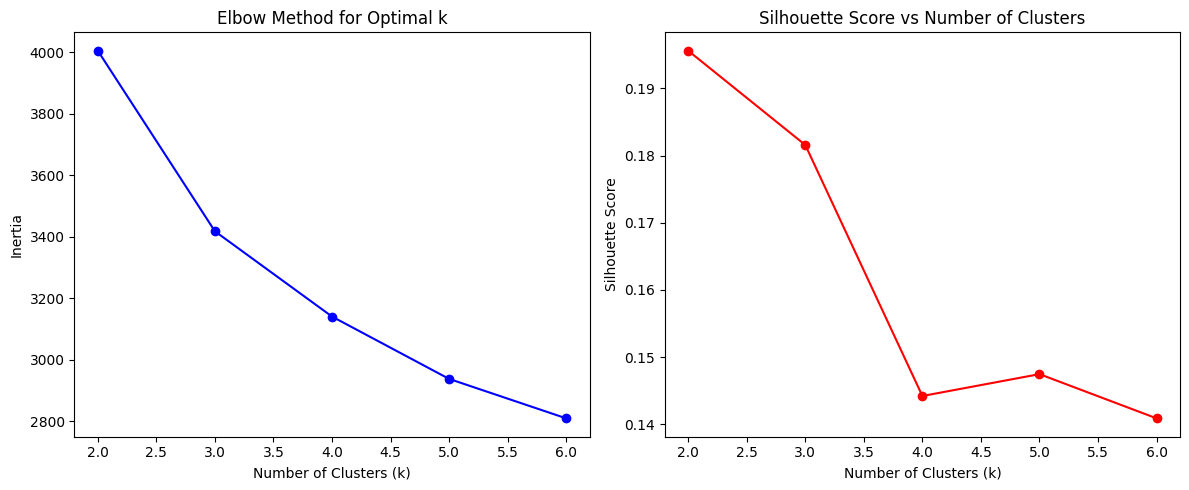


Cluster Sizes:
Cluster 0 (Hyperinflammatory): 268 patients
Cluster 1 (Septic Shock): 175 patients
Cluster 2 (Resolved Sepsis): 156 patients


In [57]:
# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Perform elbow method to validate number of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 7)

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(scaled_features)
    inertias.append(kmeans_test.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans_test.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))

# Inertia plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

plt.tight_layout()
plt.show()

# Print cluster sizes
cluster_sizes = pd.Series(df['Sepsis_Cluster'].value_counts()).sort_index()
print("\nCluster Sizes:")
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster} ({subtype_map[cluster]}): {size} patients")